In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import psycopg2

In [2]:
!pip --q install apify-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00


# Descargar Posts Instagram
Para descargar contenido de Instagram se utiliza el servicio de Apify, se requiere solamente la API KEY de la cuenta.

In [18]:
csv_instagram = pd.read_csv('instagram_municipalidades.csv')
cuentas_instagram = csv_instagram['urls'].to_list()

In [29]:
from apify_client import ApifyClient
from datetime import datetime, timedelta

# Crear instancias ApifyClient con Api Key
client = ApifyClient("API-KEY")

# Calcular la fecha de hace 7 días
today = datetime.now()
last_week = today - timedelta(days=7)
last_week_str = last_week.strftime("%Y-%m-%d")

# Input para el scraping
run_input = {
    "addParentData": False,
    "directUrls": cuentas_instagram,
    # "directUrls": [
    #     "https://www.instagram.com/muniecentral/",
    #     "https://www.instagram.com/muni_maipu/",
    #     "https://www.instagram.com/munistgo/",
    #     "https://www.instagram.com/muni_independencia/",
    #     "https://www.instagram.com/orregocl/",
    #     "https://www.instagram.com/muniprovi/",
    #     "https://www.instagram.com/gobierno.santiago/",
    #     "https://www.instagram.com/munilaflorida_/",
    #     "https://www.instagram.com/munilascondes/",
    #     "https://www.instagram.com/mpuentealto/"
    # ],
    "enhanceUserSearchWithFacebookPage": False,
    "isUserTaggedFeedURL": False,
    "resultsLimit": 50,
    "resultsType": "posts",
    "searchLimit": 10,
    "untilDate": last_week_str
}


# Ejecutar Actor de Apify
run = client.actor("apify/instagram-scraper").call(run_input=run_input)

data_json = client.dataset(run["defaultDatasetId"]).list_items().items
insta = pd.DataFrame(data_json)

In [30]:
insta.head(3)

,inputUrl,id,type,shortCode,caption,hashtags,mentions,url,commentsCount,firstComment,...,ownerId,productType,videoDuration,isSponsored,taggedUsers,musicInfo,coauthorProducers,locationName,locationId,isPinned
0,https://www.instagram.com/muniprovi/,3312668623641305934,Video,C349o_auONO,PLAN MARZO 💪\n\nEn @muniprovi nos hemos prepar...,"[SeguridadProvidencia,]","[muniprovi, evelynmatthei, carabchile]",https://www.instagram.com/p/C349o_auONO/,55,Súper me encanta. Ojalá que si llega a la pres...,...,472777410,clips,114.866,False,"[{'full_name': 'Evelyn Matthei', 'id': '228445...","{'artist_name': 'muniprovi', 'song_name': 'Ori...","[{'id': '2284459042', 'is_verified': True, 'pr...",NaN,NaN,NaN
1,https://www.instagram.com/muniprovi/,3312783179989789203,Sidecar,C35XsAVLioT,CICLO DE CINE: MUJERES EN LOS OSCAR🎥👩🏻\n\nJunt...,[],"[culturaprovidencia, teatroorienteprovidencia.]",https://www.instagram.com/p/C35XsAVLioT/,0,,...,472777410,NaN,NaN,False,[{'full_name': 'Fundación Cultural Providencia...,NaN,NaN,NaN,NaN,NaN
2,https://www.instagram.com/muniprovi/,3312193788195634560,Image,C33RrOcp_2A,💡¡BUSCAMOS EL DATO PRO!\n\n📣¡Atención! Sabemos...,[Providencia],[],https://www.instagram.com/p/C33RrOcp_2A/,236,@quimeysushi lo mejor!!,...,472777410,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN


# Descargar Comentarios
La primer scraper de Instagram descarga solamente 5 comentarios por posts. Para descargar más utilizamos `apify/instagram-comment-scraper` que permite descargar hasta 50 comentarios por posts.

In [31]:
# Input para el scraping
run_input = {
    "directUrls": insta.url.to_list(),
    "resultsLimit": 50,
}

# Ejecutar Actor de Apify
run = client.actor("apify/instagram-comment-scraper").call(run_input=run_input)

data_json = client.dataset(run["defaultDatasetId"]).list_items().items
insta_comments = pd.DataFrame(data_json)

## Juntar comentarios con los posts
En ests parte se juntan los datos descargados de los posts de instagram con los comentarios descargados de la segunda API, de los comentarios.

In [32]:
grouped_insta_comments = insta_comments.groupby('postUrl').apply(lambda x: x.drop(columns=['postUrl', 'timestamp']).to_dict(orient='records')).reset_index()
grouped_insta_comments.columns = ['postUrl', 'commentsAll']


insta_content = pd.merge(insta, grouped_insta_comments, left_on='url', right_on='postUrl', how='left')
insta_content.drop('postUrl', axis=1, inplace=True)

# Agregar Cuentas Original
Esto es necesario dado que muchos posts son publicados de manera compartida por dos cuentas a la vez. Por ejemplo, un post puede ser publicado por "escuela_X" junto con "estacion_central" y la cuenta que aparece por defecto en la columna "ownerUsername" va a ser el de "escuela_X". Nos interesa saber a cual comuna/municipalidad corresponde.

In [33]:
cuentas_originales = [cuenta.split('instagram.com/')[1].split('/')[0] for cuenta in cuentas_instagram]

In [34]:
ls_comunas = []
for _, row in insta_content.iterrows():
    tagged = row.taggedUsers
    owner = row.ownerUsername
    if isinstance(tagged, list):
        users = [user['username'] for user in tagged]
        found = [i for i in users if i in cuentas_originales]
        if len(found) > 0:
            owner = found[0]
    ls_comunas.append(owner)

insta_content['profileUser'] = ls_comunas

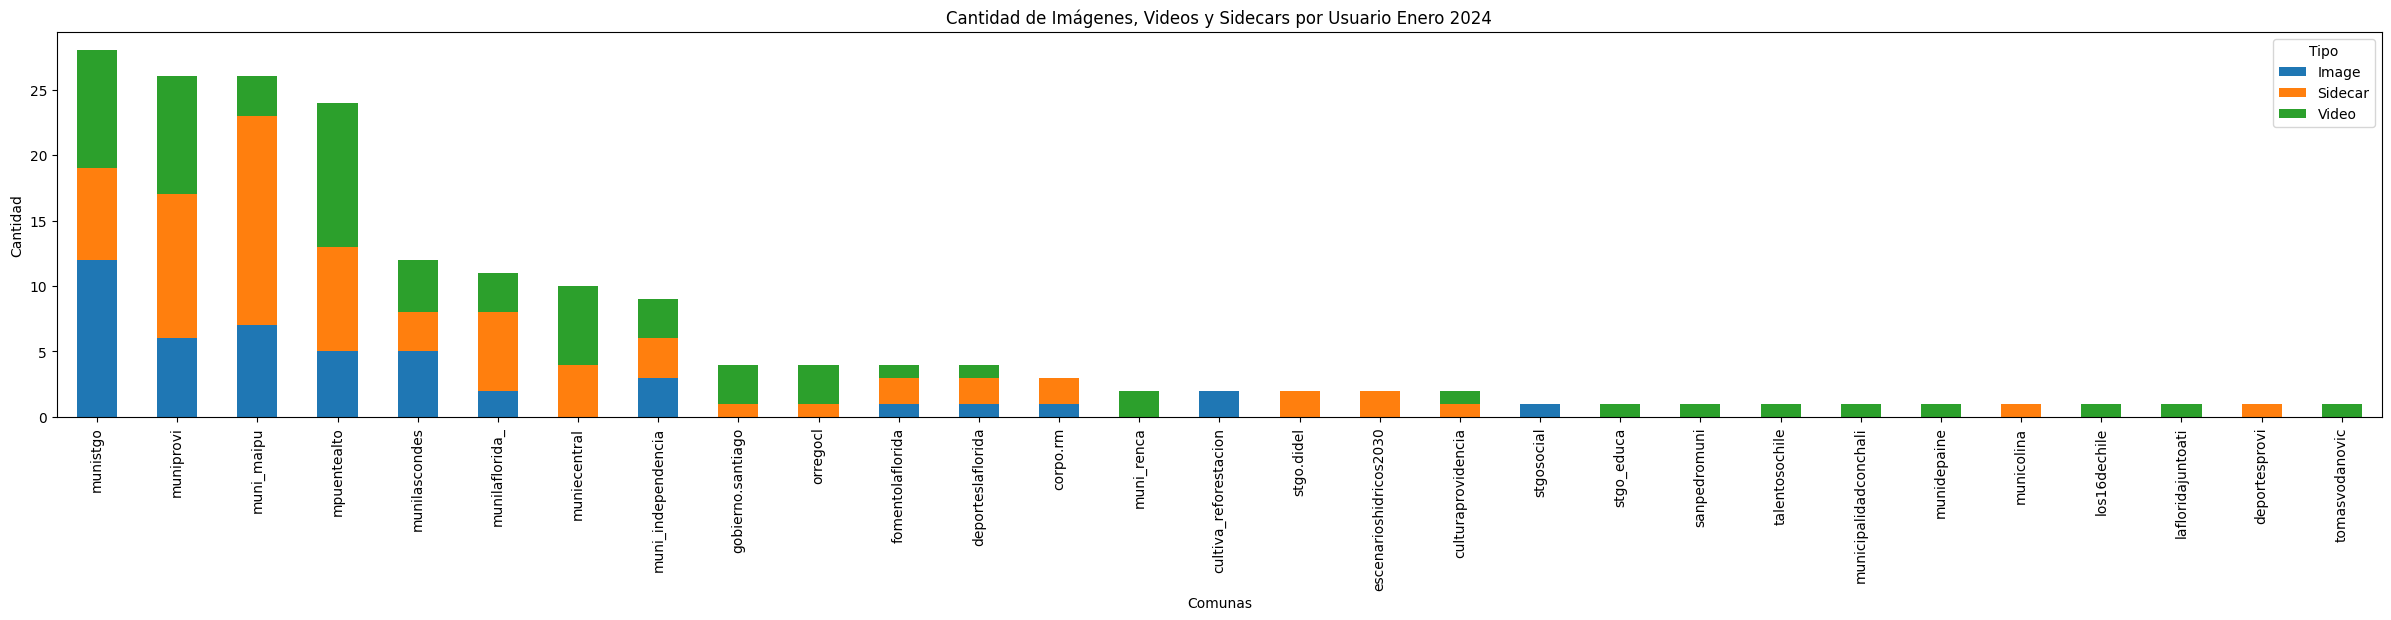

In [36]:
grouped = insta_content.groupby(['profileUser', 'type']).size().unstack(fill_value=0)
grouped['total'] = grouped.Image + grouped.Sidecar + grouped.Video
grouped = grouped.sort_values(by='total', ascending=False)

grouped.drop('total', axis=1).plot(kind='bar', stacked=True, figsize=(30, 5))
plt.xlabel('Comunas')
plt.ylabel('Cantidad')
plt.title('Cantidad de Imágenes, Videos y Sidecars por Usuario Enero 2024')
plt.xticks(rotation=90)
plt.legend(title='Tipo')
plt.show()

## Insertar datos en la BD
Acá hay dos opciones para subir los datos a una base de datos PostgreSQL

In [ ]:
insta_content = insta_content.sort_values(by='timestamp').reset_index(drop=True)

In [ ]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine

# Configuración de la conexión a la base de datos PostgreSQL
db_config = {
    'user': 'postgres',
    'password': '',
    'host': 'smartdata.cwt3zjjzj7as.sa-east-1.rds.amazonaws.com',
    'port': '5432',
    'database': 'postgres'
}


# Conectar a la base de datos
conn = psycopg2.connect(**db_config)

# Crear un motor SQLAlchemy usando la conexión
engine = create_engine(f'postgresql+psycopg2://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["database"]}')

# Utilizar el método to_sql de pandas para cargar el DataFrame en la base de datos
table_name = 'insta_gore'
insta_content.to_sql(table_name, engine, if_exists='replace', index=False)

# Cerrar la conexión
conn.close()


In [ ]:
import json

endpoint = 'smartdata.cwt3zjjzj7as.sa-east-1.rds.amazonaws.com'
database = "postgres"
username = "postgres"
password = ""
conn = psycopg2.connect(database=database,
                        host=endpoint,
                        user=username,
                        password=password,
                        port="5432")
cursor = conn.cursor()

cursor.execute("""
                    CREATE TABLE IF NOT EXISTS insta_gore (
                        id BIGINT PRIMARY KEY,
                        type VARCHAR(255),
                        shortCode VARCHAR(255),
                        caption TEXT,
                        hashtags TEXT,
                        mentions TEXT,
                        url VARCHAR(255),
                        commentsCount INTEGER,
                        firstComment TEXT,
                        comments TEXT,
                        dimensionsHeight INTEGER,
                        dimensionsWidth INTEGER,
                        displayUrl TEXT,
                        images TEXT,
                        videoUrl TEXT,
                        alt VARCHAR(255),
                        likesCount INTEGER,
                        videoViewCount NUMERIC,
                        videoPlayCount NUMERIC,
                        timestamp TIMESTAMP,
                        childPosts TEXT,
                        ownerFullName VARCHAR(255),
                        ownerUsername VARCHAR(255),
                        ownerId BIGINT,
                        productType VARCHAR(255),
                        videoDuration NUMERIC,
                        isSponsored BOOLEAN,
                        locationName VARCHAR(255),
                        locationId NUMERIC,
                        taggedUsers TEXT,
                        isPinned BOOLEAN,
                        profileUser VARCHAR(255)
                    );
                    """)
sql_query = """INSERT INTO insta_gore(
                    id,
                    type,
                    shortCode,
                    caption,
                    hashtags,
                    mentions,
                    url,
                    commentsCount,
                    firstComment,
                    commentsAll,
                    dimensionsHeight,
                    dimensionsWidth,
                    displayUrl,
                    images,
                    videoUrl,
                    alt,
                    likesCount,
                    videoViewCount,
                    videoPlayCount,
                    timestamp,
                    childPosts,
                    ownerFullName,
                    ownerUsername,
                    ownerId,
                    productType,
                    videoDuration,
                    isSponsored,
                    locationName,
                    locationId,
                    taggedUsers,
                    isPinned,
                    ) VALUES (
                    %s, %s, %s, %s, %s, %s, %s, %s,
                    %s, %s, %s, %s, %s, %s, %s, %s,
                    %s, %s, %s, %s, %s, %s, %s, %s,
                    %s, %s, %s, %s, %s, %s, %s
                    )"""
for idx, item in insta_content.iterrows():
    if not isinstance(item['commentsAll'], list):
        item['commentsAll'] = []
    if not isinstance(item['childPosts'], list):
        item['childPosts'] = []
    if not isinstance(item['taggedUsers'], list):
        item['taggedUsers'] = []
    if item['isPinned'] == True:
        item['isPinned'] = 1.0
    cursor.execute(sql_query, (item['id'],
        item['type'],
        item['shortCode'],
        item['caption'],
        item['hashtags'],
        item['mentions'],
        item['url'],
        item['commentsCount'],
        item['firstComment'],
        json.dumps(item['commentsAll']),
        item['dimensionsHeight'],
        item['dimensionsWidth'],
        item['displayUrl'],
        item['images'],
        item['videoUrl'],
        item['alt'],
        item['likesCount'],
        item['videoViewCount'],
        item['videoPlayCount'],
        item['timestamp'],
        json.dumps(item['childPosts']),
        item['ownerFullName'],
        item['ownerUsername'],
        item['ownerId'],
        item['productType'],
        item['videoDuration'],
        item['isSponsored'],
        item['locationName'],
        item['locationId'],
        json.dumps(item['taggedUsers']),
        item['isPinned']))
    conn.commit()

# Cierra el cursor y la conexión
cursor.close()
conn.close()